In [1]:
!git lfs install
!git clone https://huggingface.co/datasets/ssuai/question_quality_assessment data

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'data'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 2.85 MiB | 29.75 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Filtering content: 100% (956/956), 1.66 GiB | 46.06 MiB/s, done.


In [2]:
import pandas as pd

donwload the dataset and put under `data`

## Load user responses

In [569]:
data = pd.read_csv('data/train_data/train_task_3_4.csv')
data.head()

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
0,898,2111,280203,1,2,2
1,767,3062,55638,1,3,3
2,165,1156,386475,1,2,2
3,490,1653,997498,1,4,4
4,298,3912,578636,1,3,3


In [570]:
metadata = pd.read_csv('data/metadata/answer_metadata_task_3_4.csv')
metadata.head()

,AnswerId,DateAnswered,Confidence,GroupId,QuizId,SchemeOfWorkId
0,1451945,2019-10-30 14:34:00.000,NaN,4,32,52562.0
1,45325,2020-01-06 18:53:00.000,75.0,185,66,52562.0
2,687013,2020-01-18 10:52:00.000,NaN,235,64,52562.0
3,91254,2020-02-29 17:25:00.000,NaN,194,97,52562.0
4,1225855,2020-03-06 15:07:00.000,NaN,95,115,52562.0


In [571]:
data = pd.merge(data, metadata)

tot_avg = data['Confidence'].mean()
print(tot_avg)
data['Confidence'] = data['Confidence'].fillna(tot_avg)

data.head()

73.94761682081125


,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue,DateAnswered,Confidence,GroupId,QuizId,SchemeOfWorkId
0,898,2111,280203,1,2,2,2019-12-08 17:47:00.000,73.947617,95,86,52562.0
1,767,3062,55638,1,3,3,2019-10-27 20:54:00.000,25.000000,115,39,52562.0
2,165,1156,386475,1,2,2,2019-10-06 20:16:00.000,73.947617,101,39,52562.0
3,490,1653,997498,1,4,4,2020-02-27 17:40:00.000,73.947617,46,115,52562.0
4,298,3912,578636,1,3,3,2019-12-27 16:07:00.000,73.947617,314,78,52562.0


In [572]:
import math
A = list()
for k,df in data.groupby('QuestionId'):
  avg = df['Confidence'].mean()
  ac = df['IsCorrect'].mean()
  A.append([avg - math.log(ac), k])
print(len(A))
A.sort()
print(A[0:5])

948
[[61.43579872963794, 932], [64.0557025864912, 169], [65.27840927171133, 880], [65.92003595443065, 706], [65.93649217801246, 491]]


In [573]:
res = pd.read_csv('submission/template.csv')
res.head()

,QuestionId,ranking
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN


In [574]:
for i in range(len(A)):
  res.loc[A[i][1],'ranking'] = i

res = res.astype('int')
res.head()

,QuestionId,ranking
0,0,62
1,1,373
2,2,126
3,3,887
4,4,82


In [575]:
res.to_csv('submission/20192434.csv')

In [576]:
# load evaluators' score on "validation" set
eval_validation = pd.read_csv('data/test_data/quality_response_remapped_public.csv')
print(len(eval_validation))
eval_validation.head()

25


,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,0,0,909,318,2,2,2,1.0,2
1,16,16,285,609,2,2,2,2.0,2
2,48,48,132,271,1,2,2,2.0,1
3,38,38,704,127,2,2,1,2.0,2
4,33,33,16,586,1,1,2,2.0,2


<Axes: >

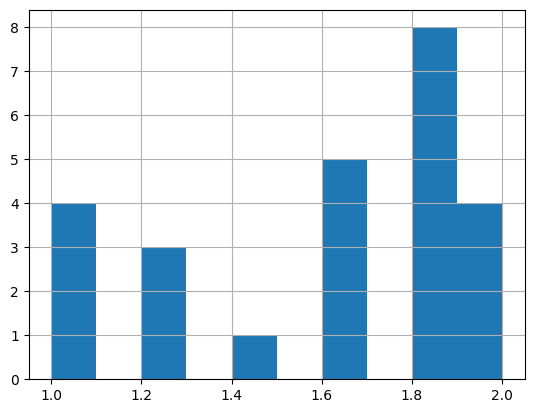

In [577]:
# take the average of 5 evaulators` scores
eval_validation['score'] = eval_validation.filter(regex='^T', axis = 1).mean(axis=1)
eval_validation['score'].hist()

<Axes: >

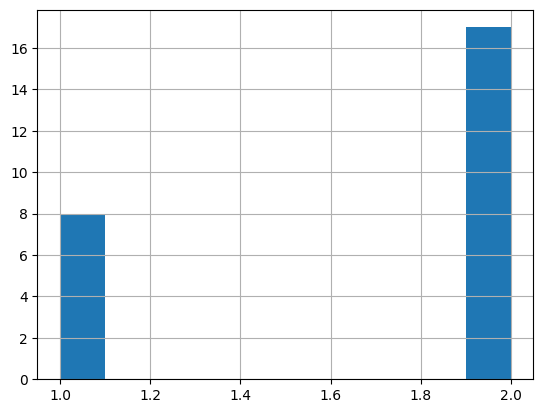

In [578]:
# decide preference
import numpy as np
def calc_preference(scores):
    preference = np.ones(len(scores), dtype=int)

    idx_two = scores > 1.5
    preference[idx_two] = 2

    return list(preference)

eval_validation['preference'] = calc_preference(eval_validation['score'])
# eval_dev[]
# eval_dev['score']
eval_validation['preference'].hist()

In [579]:
eval_test = pd.read_csv('data/test_data/quality_response_remapped_private.csv')
print(len(eval_test))
eval_test.head()

25


,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,15,15,145,762,2,2,2,2.0,2
1,31,31,307,208,1,1,1,2.0,1
2,25,25,278,195,1,1,1,1.0,1
3,3,3,13,153,2,2,2,2.0,2
4,40,40,23,100,2,1,1,1.0,1


<Axes: >

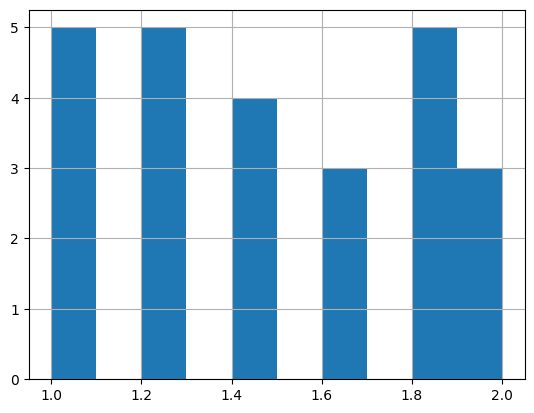

In [580]:
# take the average of scores by 5 evaulators
eval_test['score'] = eval_test.filter(regex='^T', axis = 1).mean(axis=1)
eval_test['score'].hist()

## Evaluate
code from https://competitions.codalab.org/forums/22145/4564/

In [581]:
template = pd.read_csv('submission/20192434.csv')
len(template)

948

In [582]:
template.head()

,Unnamed: 0,QuestionId,ranking
0,0,0,62
1,1,1,373
2,2,2,126
3,3,3,887
4,4,4,82


In [583]:
def evaluate(truth, submission):
    # extract ranking
    left = list(truth.left)
    right = list(truth.right)
#     if len(left) != len(right):
#     message = 'left and right lengths are not the same'
#     sys.exit(message)

    submission_left = []
    submission_right = []
    submission_preference = []
    for idx in range(len(left)):
        submission_left.append(left[idx])
        submission_right.append(right[idx])
        ranking_left = submission[submission.QuestionId==left[idx]].ranking.values[0]
        ranking_right = submission[submission.QuestionId==right[idx]].ranking.values[0]
        preference = 1 if ranking_left < ranking_right else 2
        submission_preference.append(preference)
    print(submission_preference)

    T = []
    T.append(list(truth.T1_ALR))
    T.append(list(truth.T2_CL))
    T.append(list(truth.T3_GF))
    T.append(list(truth.T4_MQ))
    T.append(list(truth.T5_NS))

    for k in range(5):
      cnt = 0
      for i in range(len(submission_preference)):
        if T[k][i] == submission_preference[i]:
          cnt += 1
      print(cnt / len(submission_preference))

evaluate(eval_validation, template)

[1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1]
0.68
0.64
0.72
0.68
0.6


In [584]:
eval_validation.head()

,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS,score,preference
0,0,0,909,318,2,2,2,1.0,2,1.8,2
1,16,16,285,609,2,2,2,2.0,2,2.0,2
2,48,48,132,271,1,2,2,2.0,1,1.6,2
3,38,38,704,127,2,2,1,2.0,2,1.8,2
4,33,33,16,586,1,1,2,2.0,2,1.6,2


In [585]:
eval_test.head()

,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS,score
0,15,15,145,762,2,2,2,2.0,2,2.0
1,31,31,307,208,1,1,1,2.0,1,1.2
2,25,25,278,195,1,1,1,1.0,1,1.0
3,3,3,13,153,2,2,2,2.0,2,2.0
4,40,40,23,100,2,1,1,1.0,1,1.2


In [586]:
evaluate(eval_test, template)

[2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1]
0.76
0.64
0.56
0.56
0.84


In [587]:
def evaluate_forall_pair(truth):
    T = []
    T.append(list(truth.T1_ALR))
    T.append(list(truth.T2_CL))
    T.append(list(truth.T3_GF))
    T.append(list(truth.T4_MQ))
    T.append(list(truth.T5_NS))

    for k in range(5):
      for nk in range(5):
        cnt = 0
        for i in range(len(T[0])):
          if T[k][i] == T[nk][i]:
            cnt += 1
        print(cnt / len(T[0]), end=' ')
        if nk == 4:
          print()

evaluate_forall_pair(eval_validation)

1.0 0.72 0.72 0.6 0.68 
0.72 1.0 0.76 0.64 0.64 
0.72 0.76 1.0 0.72 0.72 
0.6 0.64 0.72 1.0 0.6 
0.68 0.64 0.72 0.6 1.0 


In [588]:
evaluate_forall_pair(eval_test)

1.0 0.8 0.64 0.56 0.76 
0.8 1.0 0.6 0.56 0.72 
0.64 0.6 1.0 0.68 0.64 
0.56 0.56 0.68 0.96 0.64 
0.76 0.72 0.64 0.64 1.0 
